In [283]:
import numpy as np
import copy
import itertools as it
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

validPaths = np.array([[1,0,1,1,0,0,0,0,0],[1,0,0,1,1,1,0,0,0],[0,1,0,0,0,0,1,0,0],[1,0,0,0,1,0,0,1,0],[1,0,0,0,0,0,1,0,1]])

lossScalars = [1,2,3,4,1,2,3,4,2]

edgeWeights = [2,2,4,5,1,1,3,2,4]

def genUtilities(lenN, lenE, boundsTuple):
    
    utilitiesMatrix = np.zeros((lenN, lenE))
    
    for row in range(len(utilitiesMatrix)):
        
        for col in range(len(utilitiesMatrix.T)):
            
            utilitiesMatrix[row][col] = np.random.uniform(boundsTuple[0], boundsTuple[1])
            
    return utilitiesMatrix

def genInitialPaths(paths, lenN):
    
    initialPaths = []
    
    for i in range(lenN):

        currPath = paths[np.random.randint(0, len(paths))]
        initialPaths.append(currPath)
        
    return initialPaths

def getCost(currPaths, aIndex, lossScalars, edgeWeights, utilitiesMatrix):
    
    edgeCounts = np.sum(currPaths, axis=0)
    edgeCosts = edgeCounts * edgeWeights * lossScalars
    edgeCostsWithUtility = edgeCosts * utilitiesMatrix[aIndex]
    
    return edgeCostsWithUtility @ currPaths[aIndex]

def getAllCosts(currPaths, lossScalars, edgeWeights, utilitiesMatrix, getPaths = False):
    
    totCost = 0
    
    for currAgent in range(len(currPaths)):

        nextCost = getCost(currPaths, currAgent, lossScalars, edgeWeights, utilitiesMatrix)
        
        totCost += nextCost
        
    return totCost
    

def evalCurrentAction(currPaths, aIndex, lossScalars, edgeWeights, utilitiesMatrix):
    
    bestPathOption = currPaths[aIndex]
    currCost = getCost(currPaths, aIndex, lossScalars, edgeWeights, utilitiesMatrix)
    mutatedPaths = copy.deepcopy(currPaths)
    
    for i in range(len(validPaths)):
        
        mutatedPaths[aIndex] = validPaths[i]
        newCost =  getCost(mutatedPaths, aIndex, lossScalars, edgeWeights, utilitiesMatrix)

        if newCost < currCost:
  
            bestPathOption = validPaths[i]
            currCost = newCost
            
    
    return bestPathOption, currCost  

def simEquilibrium(initialPaths, validPaths, utilitiesMatrix, lossScalars, edgeWeights):
    
    currPaths = initialPaths

    updating = True

    while updating:

        iterUpdates = False

        for a_i in range(len(currPaths)):

            currBestPath, currCost = evalCurrentAction(currPaths, a_i, lossScalars, edgeWeights, utilitiesMatrix)
            
            if np.array_equal(currBestPath, currPaths[a_i])==False:

                iterUpdates = True
                currPaths[a_i] = currBestPath

                break

        if not iterUpdates:

            updating = False
            
    return getAllCosts(currPaths, lossScalars, edgeWeights, utilitiesMatrix), currPaths

def translatePermutation(validPaths, encodedSolution):
    
    paths = []
    
    for i in encodedSolution:
        
        paths.append(validPaths[i])
        
    return paths

def simPoA(nIter, agentSize, validPaths, lossScalars, edgeWeights, getVars = False):
    
    results = []
    initPaths = []
    eqPathsArray = []
    utilMat = []
    
    for instance in range(nIter):
        
        initialPaths = genInitialPaths(validPaths, agentSize)

        utilities = genUtilities(agentSize, 9, (4,4.1))
        
#         utilitiesPathMeans = []
#         for each in utilities.T:
    
#             utilitiesPathMeans.append(np.mean(each))

        initPaths.append(copy.deepcopy(initialPaths))
        utilMat.append(utilities)
        
        randomCost = getAllCosts(initialPaths, lossScalars, edgeWeights, utilities)
        eqCost, eqPaths = simEquilibrium(initialPaths, validPaths, utilities, lossScalars, edgeWeights)
        eqPathsArray.append(copy.deepcopy(eqPaths))
    
        naivePaths = np.tile(validPaths[4], (agentSize,1))
        naiveCost = getAllCosts(naivePaths, lossScalars, edgeWeights, utilities)

        bestCost = np.Inf
        potentialSolutions = list(it.product(range(5),repeat=agentSize))

        for i in potentialSolutions:

            currPaths = translatePermutation(validPaths,i)

            currCost = getAllCosts(currPaths, lossScalars, edgeWeights, utilities)

            if currCost < bestCost:

                bestCost = currCost
                bestPaths = currPaths
                
        results.append([bestCost,eqCost,naiveCost,randomCost])
    
    if getVars:
        
        return results, initPaths, eqPathsArray, utilMat
    
    else:
        return results
    
def processResults(results):
    
    allResults = []

    for obs in range(len(results)):
        metrics = []
        for metric in range(1,4):

            metrics.append(results[obs][0] / results[obs][metric])

        allResults.append(metrics)

    allResults = pd.DataFrame(allResults)

    allResults = allResults.rename(columns={0: "% eq", 1: "% naive",2: "% random"})

    allResults = pd.melt(allResults)
    
    return allResults

def extractEqfromDf(results):
    
    n = int(len(results) / 3)
    
    return(results[:n]['value'])

def countChangedPaths(initialPaths, eqPaths):
    
    count = 0
    
    for i in range(len(initialPaths)):
        
        if np.array_equal(initialPaths[i],eqPaths[i])==False:
            
            count += 1
            
    return count
        

In [2]:
utilities = genUtilities(30, 9, (0.5,1.5))
initialPaths = genInitialPaths(validPaths, 30)

In [ ]:
simEquilibrium(initialPaths, validPaths, utilities, lossScalars, edgeWeights)

In [332]:
agentSize = 5

initialPaths = genInitialPaths(validPaths, agentSize)

getAllCosts(initialPaths, lossScalars, edgeWeights, utilities)

342.4531315034628

In [ ]:
results = processResults(size4)

C:\Users\Tanner\AppData\Local\Temp\ipykernel_21748\4014898553.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


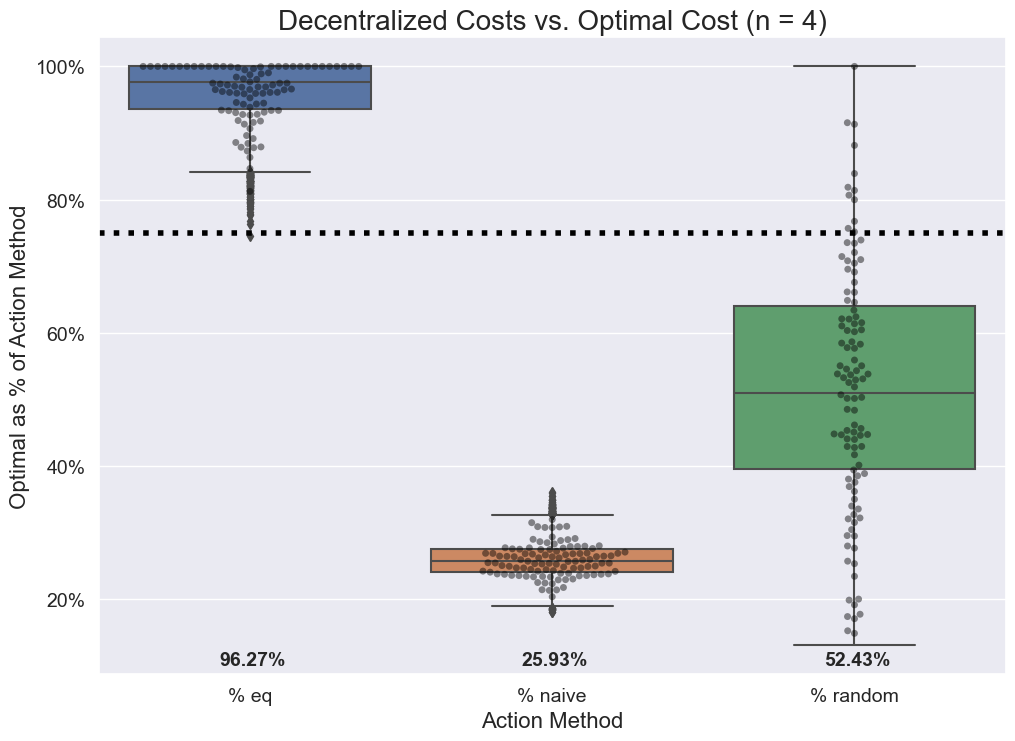

In [155]:
results = size4
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="variable", y="value", data=results)
ax = sns.swarmplot(x="variable", y="value", data=results.sample(300).sort_index(), color="0", alpha=.45)
#.sample(300).sort_index()
ylabels = ['{:,.0f}'.format(y) + '%' for y in ax.get_yticks()*100]
ax.set_yticklabels(ylabels)
ax.axhline(0.75, color = "black", linestyle="dotted", linewidth = "4")
plt.xlabel(xlabel='Action Method', size="16")
plt.ylabel(ylabel='Optimal as % of Action Method', size="16")
plt.title(label = "Decentralized Costs vs. Optimal Cost (n = 4)", size="20")
ax.tick_params(axis='both', which='major', labelsize=14)

for i in range(3):
        currCol = ['% eq', '% naive', '% random'][i]
        y = np.mean(results['value'][results['variable'] == currCol])
        ax.text(i-.1, np.min(size8["value"]-.08), str(np.round(y*100,2)) + "%", weight="bold",size = "14")

plt.show()

In [ ]:
#### dfNames = []

for i in range(4,11):
    
    string = "size" + str(i)
    dfNames.append(string)

mins = []
    
for df in dfNames:
    
    mins.append(np.min(extractEqfromDf(globals()[df])))

ones = []    

for df in dfNames: 

    stripped = extractEqfromDf(globals()[df])
    ones.append(len(stripped[stripped == 1]) / len(stripped))
    
sims = []

for df in dfNames: 

    stripped = extractEqfromDf(globals()[df])
    sims.append(len(stripped))

C:\Users\Tanner\AppData\Local\Temp\ipykernel_21748\2424238939.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


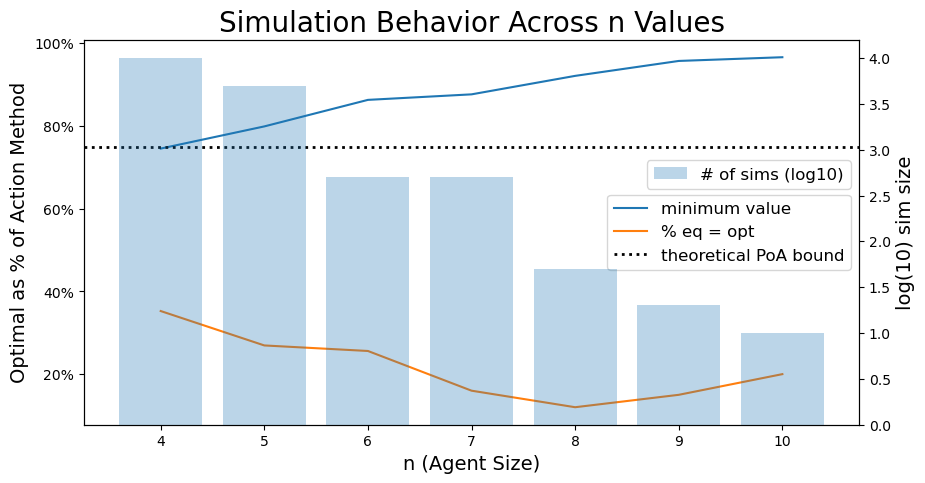

In [160]:
import matplotlib
matplotlib.rc_file_defaults()


ylabels = ['{:,.0f}'.format(y) + '%' for y in ax.get_yticks()*100]

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(np.arange(4,11,1),mins, label = "minimum value")
plt.plot(np.arange(4,11,1),ones, label = "% eq = opt")
plt.axhline(0.75, color = "black", linestyle="dotted", linewidth = "2", label = "theoretical PoA bound")
ax.set_yticklabels(ylabels)
plt.ylabel("Optimal as % of Action Method", size="14")
plt.xlabel("n (Agent Size)", size="14")
plt.title("Simulation Behavior Across n Values", size="20")
ax.legend(loc="center right", prop={'size': 12})

ax2 = ax.twinx()
ax2.bar(np.arange(4,11,1), np.log10(sims), alpha=0.3, label = "# of sims (log10)")
ax2.set_ylabel('log(10) sim size', size="14")


ax2.legend(loc="center right", bbox_to_anchor=(0.5, 0.4, 0.5, 0.5), prop={'size': 12})

In [285]:
size4, size4initPaths, size4EqPaths, size4UtilMat = simPoA(5000, 4, validPaths, lossScalars, edgeWeights, getVars = True)
size4 = processResults(size4)


In [286]:
size4 = size4[size4['variable']=='% eq']

size4['initPaths'] = size4initPaths
size4['eqPaths'] = size4EqPaths
size4['utilMat'] = size4UtilMat


size4 = size4.sort_values(by=['value']).reset_index()

changes = []

for i in range(len(size4)):

    changes.append(countChangedPaths(size4['initPaths'][i],size4['eqPaths'][i]))
    
size4['changes'] = changes